In [ ]:
%pip install opencv-python numpy pandas matplotlib scikit-image scikit-learn scipy tqdm

# **Lab3 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure


import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Load Image

In [ ]:
### START CODE HERE ###
image = cv2.imread("./asset/bird3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/1.png?raw=true)
</details>

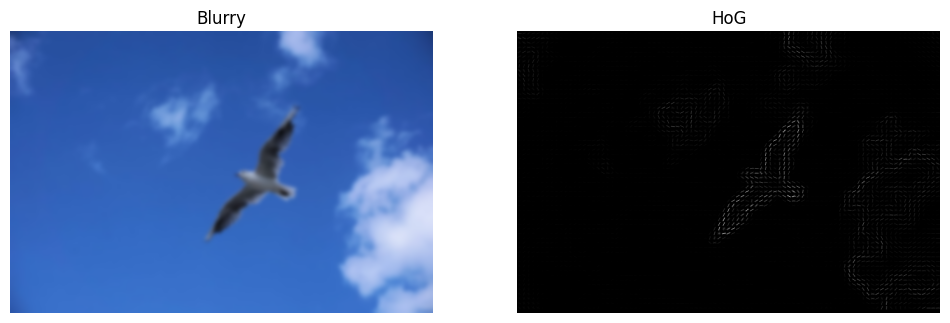

In [ ]:
### START CODE HERE ###

blurry_image = cv2.GaussianBlur(image, (5, 5), 0)

# gray_blurry_image = cv2.cvtColor(blurry_image, cv2.COLOR_RGB2GRAY)
fd, hog_image = hog(blurry_image,pixels_per_cell=(3, 3), channel_axis=2, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(blurry_image, cmap='gray')  
ax[0].set_title('Blurry Image')
ax[1].imshow(hog_image, cmap='gray')
ax[1].set_title('HOG Features')
plt.show()
### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [ ]:
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.h, self.w, _ = image.shape

        if self.h < tile_size[0] or self.w < tile_size[1]:
            raise ValueError("Tile size must be smaller than the image size.")

        self.hGrid = np.arange(0, self.h - tile_size[0] + 1, stride[0])
        self.wGrid = np.arange(0, self.w - tile_size[1] + 1, stride[1])

        self.hog_features = []
        self.hog_images = []

        self.extract_hog_features()

    def extract_hog_features(self):
        for y in self.hGrid:
            for x in self.wGrid:
                tile = self.image[y : y + self.tile_size[0], x : x + self.tile_size[1]]
                gray_tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)

                features, hog_image = hog(
                    gray_tile,
                    visualize=True,
                    feature_vector=True,
                )

                self.hog_features.append(features)
                self.hog_images.append(hog_image)

    def plot_hog_images(self):
        """
        Plot all HOG visualizations in a grid.
        """
        n_rows, n_cols = self.get_num_grid()
        plt.style.use('dark_background')
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
        fig.patch.set_facecolor('black')

        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1 or n_cols == 1:
            axes = axes.reshape((n_rows, n_cols))

        for i in range(n_rows):
            for j in range(n_cols):
                index = i * n_cols + j
                axes[i, j].imshow(self.hog_images[index], cmap="gray")
                axes[i, j].axis("off")

        plt.tight_layout()
        plt.show()

    def get_num_grid(self):
        return len(self.hGrid), len(self.wGrid)


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/2.png)
</details>

In [ ]:
### START CODE HERE ###
tile_size = (48, 48)
stride = (6, 6)
hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###


TypeError: HOGSubimageExtractor.__init__() missing 2 required positional arguments: 'tile_size' and 'stride'

## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [ ]:
### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        # Initialize KMeans with proper parameters
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        
        # Convert HOG features to numpy array and perform clustering
        hog_features_array = np.array(self.hog_extractor.hog_features)
        cluster_labels = kmeans.fit_predict(hog_features_array)
        
        # Get grid dimensions
        n_rows, n_cols = self.hog_extractor.get_num_grid()
        
        # Reshape cluster labels into 2D grid array
        self.cluster_array = cluster_labels.reshape(n_rows, n_cols)
        
        # Find connected components for each cluster
        self.all_labels = measure.label(self.cluster_array, connectivity=2)

    def plot_cluster_and_labels(self):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot cluster assignments
        im1 = axes[0].imshow(self.cluster_array, cmap='viridis')
        axes[0].set_title('K-Means Clusters')
        axes[0].axis('off')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot connected component labels
        im2 = axes[1].imshow(self.all_labels, cmap='nipy_spectral')
        axes[1].set_title('Connected Components')
        axes[1].axis('off')
        plt.colorbar(im2, ax=axes[1])
        
        plt.tight_layout()
        plt.show()

    def get_bounding_boxes(self):
        # Clear previous bounding boxes
        self.bounding_boxes = []
        
        # Get properties of each connected component
        props = measure.regionprops(self.all_labels)
        
        for prop in props:
            # Get bounding box coordinates (min_row, min_col, max_row, max_col)
            min_row, min_col, max_row, max_col = prop.bbox
            
            # Convert grid coordinates to image coordinates
            stride_h, stride_w = self.hog_extractor.stride
            tile_h, tile_w = self.hog_extractor.tile_size
            
            # Calculate actual image coordinates
            y1 = min_row * stride_h
            x1 = min_col * stride_w
            y2 = max_row * stride_h + tile_h
            x2 = max_col * stride_w + tile_w
            
            # Ensure coordinates are within image bounds
            y1 = max(0, y1)
            x1 = max(0, x1)
            y2 = min(self.hog_extractor.h, y2)
            x2 = min(self.hog_extractor.w, x2)
            
            self.bounding_boxes.append((x1, y1, x2, y2))
        
        return self.bounding_boxes
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [ ]:
### START CODE HERE ###
def draw_bbox(image, bboxes):
    """
    Draw bounding boxes on the image.
    
    Args:
        image (np.ndarray): Input image
        bboxes (list): List of bounding boxes in format (x1, y1, x2, y2)
    
    Returns:
        np.ndarray: Image with bounding boxes drawn
    """
    # Create a copy to avoid modifying the original image
    img_with_bbox = image.copy()
    
    # Generate different colors for each bounding box
    colors = [
        (255, 0, 0),    # Red
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
        (255, 255, 0),  # Yellow
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Cyan
        (255, 128, 0),  # Orange
        (128, 0, 255),  # Purple
    ]
    
    # Draw each bounding box
    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = bbox
        
        # Convert to integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Select color (cycle through colors if more boxes than colors)
        color = colors[i % len(colors)]
        
        # Draw rectangle
        cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), color, thickness=2)
        
        # Add label with box number
        cv2.putText(img_with_bbox, f'Box {i+1}', (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, thickness=2)
    
    return img_with_bbox
### END CODE HERE ###

Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/4.png?raw=true)
</details>

In [ ]:
# Fix: Add missing required arguments
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()

# Fix: Assign the result and display it
result_image = draw_bbox(image, bboxes)

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(f'Number of detected regions: {len(bboxes)}')

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

In [ ]:
### START CODE HERE ###

tile_size = (24, 24)
stride = (6, 6)
hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
hog_extractor.plot_hog_images()
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()

result_image = draw_bbox(image, bboxes)
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
### END CODE HERE ###

In [ ]:
### START CODE HERE ###

tile_size = (24, 24)
stride = (3, 3)
hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
hog_extractor.plot_hog_images()
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()

result_image = draw_bbox(image, bboxes)
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



### END CODE HERE ###

In [ ]:
### START CODE HERE ###

tile_size = (64, 64)
stride = (8, 8)
hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
hog_extractor.plot_hog_images()
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()

result_image = draw_bbox(image, bboxes)
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/q5.jpg?raw=true)


1. The **larger the kernel size**, the more blurness, and the **larger the standard deviation (σ)**, the **wider the distribution of weights** around the kernel center, which implies **more blurness**.

2. **HOG Parameters Trade-offs:**
   - **pixels_per_cell**: The **fewer pixels per cell**, the **more fine details** captured but **more noise sensitivity**; the **more pixels per cell**, the **less noise** and **more stable features** but **fewer fine details**
   - **cells_per_block**: The **fewer cells per block** (e.g., 1×1), the **higher spatial precision** but **less robust to lighting variations**; the **more cells per block** (e.g., 3×3), the **better normalization** and **more robust to illumination changes** but **less spatial detail**

3. **Tile Size Trade-offs:**
   - **Smaller tile size** effectively **detects fine details and small objects** but **more computationally expensive** and **more sensitive to noise**
   - **Larger tile size** effectively **detects large objects and global patterns** but **may miss small details** and **less precise localization**

4. Lower precision may cause multiple objects to be mistakenly detected as an object.

5. Using too many clusters may result in over-segmentation, producing more groups than necessary. Conversely, using too few clusters can lead to under-segmentation, merging distinct groups into one.